In [5]:
from IPython.core.display import HTML
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
pd.set_option("display.precision",9)
pd.options.display.max_columns = None
HTML("""
<style>
body
{
  filter: invert(1);
}
.notebook_app {
    background-color: black;
}
.container {
    width :100% !important;
}
</style>
""")

In [6]:
import pandas as pd
import numpy as np
import datetime
import copy
import time
import os
import json
import psycopg2
import warnings
warnings.filterwarnings('ignore')

import logging
import string


# host = "172.16.100.156"
host = "192.168.151.157"
database = "bcast"
username = "postgres"
password = "postgres123"

/usr/local/lib64/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [7]:
from irage_helper.irage import SymserverRequest
from datetime import datetime

In [8]:
!mkdir -p data

In [9]:
"30th apr finnifty 1:50 - 2:15"

'30th apr finnifty 1:50 - 2:15'

In [10]:
trading_dates = ['20240430']
contract_header_for_dates = []
all_syminfo = {}
for next_nearest_expiry in trading_dates:
    if not os.path.exists(f'data/{next_nearest_expiry}.csv'):
        contract_header_for_dates.append(next_nearest_expiry)
        symserver = SymserverRequest()
        request = {"cmd":"symbol", 'exch':'NSEFO',
                   'date':next_nearest_expiry,
                  }

        resp = symserver.get_zmq_response(request)
        assert resp['status'] == 200, "Sym server request failed"
        syminfo = pd.DataFrame.from_records(data=resp['sym'])
        syminfo['date'] = next_nearest_expiry
        syminfo.expiry = syminfo.expiry + 315513000
        syminfo["expiry_date"] = pd.to_datetime(syminfo.expiry,unit="s").dt.strftime('%Y%m%d')

        syminfo.to_csv(f'data/{next_nearest_expiry}.csv',index=False)
    else:
        syminfo = pd.read_csv(f'data/{next_nearest_expiry}.csv')
        syminfo.expiry_date = syminfo.expiry_date.astype(str)
        syminfo['date'] = syminfo['date'].astype(str)
    all_syminfo[next_nearest_expiry] = syminfo

In [11]:
syminfo = all_syminfo['20240430'].query('underlying == "FINNIFTY" & expiry_date == date')

In [12]:
syminfo.head()

,id,underlying,expiry,strike,option_type,tick_size,lot_size,name,exch,segment,security_type,date,expiry_date
50,35051,FINNIFTY,1714467600,-1,XX,5,40,FINNIFTY24APRFUT,NSE,FO,FUTIDX,20240430,20240430
152,35153,FINNIFTY,1714467600,1570000,CE,5,40,FINNIFTY24APR15700CE,NSE,FO,OPTIDX,20240430,20240430
204,35205,FINNIFTY,1714467600,1570000,PE,5,40,FINNIFTY24APR15700PE,NSE,FO,OPTIDX,20240430,20240430
205,35206,FINNIFTY,1714467600,1580000,CE,5,40,FINNIFTY24APR15800CE,NSE,FO,OPTIDX,20240430,20240430
206,35207,FINNIFTY,1714467600,1580000,PE,5,40,FINNIFTY24APR15800PE,NSE,FO,OPTIDX,20240430,20240430


In [13]:
connection = psycopg2.connect(host=host, database=database, user=username, password=password,port=5442) 
connection.autocommit = True
cursor = connection.cursor()
q_header = """SELECT column_name, data_type
 FROM information_schema.columns
 WHERE table_name = 'stock_info'"""
cursor.execute(q_header)

headers = pd.DataFrame(cursor.fetchall(),columns=['column_name','data_type']).drop_duplicates()

In [14]:
headers

,column_name,data_type
0,timestamp,timestamp without time zone
1,bid_price,bigint
2,ask_price,bigint
3,ltp,bigint
4,volume,bigint
5,total_buyqty,double precision
6,total_sellqty,double precision
7,iv,real
8,bid_qty,integer
9,ask_qty,integer


In [15]:
symids = f"({','.join(syminfo.id.astype(str).unique().tolist())})"

In [16]:
%%time
try:
    q = f"""SELECT * FROM nse_fo.stock_info WHERE timestamp > '20240430' and timestamp < '20240501' and symid IN {symids};"""
    cursor.execute(q)
    raw_data = cursor.fetchall()
except Exception as e:
    y = e 
    print(e)

CPU times: user 5.3 s, sys: 2.1 s, total: 7.4 s
Wall time: 9.6 s


In [17]:
bcast_raw = pd.DataFrame(raw_data,columns=headers.column_name.tolist()).astype({'symid':int})

In [18]:
bcast_raw.timestamp = bcast_raw.timestamp.dt.tz_localize('UTC').dt.tz_convert('Asia/Kolkata')

In [19]:
bcast_raw.head()

,timestamp,bid_price,ask_price,ltp,volume,total_buyqty,total_sellqty,iv,bid_qty,ask_qty,ltq,atp,oi,open,high,low,close,symid
0,2024-04-30 09:14:59.724955+05:30,15,30,40,0,141200.0,2600.0,0.0,54000,1800,120,0,0,0,0,0,40,36899
1,2024-04-30 09:14:59.725903+05:30,15,40,30,0,286200.0,400.0,0.0,72000,400,160,0,0,0,0,0,30,36928
2,2024-04-30 09:14:59.725903+05:30,10,40,40,0,14800.0,400.0,0.0,9000,400,400,0,0,0,0,0,45,36939
3,2024-04-30 09:14:59.726163+05:30,25,0,25,0,16560.0,0.0,0.0,360,0,200,0,0,0,0,0,50,36948
4,2024-04-30 09:14:59.726163+05:30,15,40,35,0,18600.0,400.0,0.0,1640,400,40,0,0,0,0,0,50,36952


In [20]:
syminfo.head()

,id,underlying,expiry,strike,option_type,tick_size,lot_size,name,exch,segment,security_type,date,expiry_date
50,35051,FINNIFTY,1714467600,-1,XX,5,40,FINNIFTY24APRFUT,NSE,FO,FUTIDX,20240430,20240430
152,35153,FINNIFTY,1714467600,1570000,CE,5,40,FINNIFTY24APR15700CE,NSE,FO,OPTIDX,20240430,20240430
204,35205,FINNIFTY,1714467600,1570000,PE,5,40,FINNIFTY24APR15700PE,NSE,FO,OPTIDX,20240430,20240430
205,35206,FINNIFTY,1714467600,1580000,CE,5,40,FINNIFTY24APR15800CE,NSE,FO,OPTIDX,20240430,20240430
206,35207,FINNIFTY,1714467600,1580000,PE,5,40,FINNIFTY24APR15800PE,NSE,FO,OPTIDX,20240430,20240430


In [21]:
bcast_w_syminfo = pd.merge(bcast_raw,syminfo[['id','name','strike']].rename(columns={'id':'symid'}),how='left',on='symid').sort_values('timestamp')

In [22]:
bcast_w_syminfo.head()

,timestamp,bid_price,ask_price,ltp,volume,total_buyqty,total_sellqty,iv,bid_qty,ask_qty,ltq,atp,oi,open,high,low,close,symid,name,strike
0,2024-04-30 09:14:59.724955+05:30,15,30,40,0,141200.0,2600.0,0.0,54000,1800,120,0,0,0,0,0,40,36899,FINNIFTY24APR17000PE,1700000
1,2024-04-30 09:14:59.725903+05:30,15,40,30,0,286200.0,400.0,0.0,72000,400,160,0,0,0,0,0,30,36928,FINNIFTY24APR17500PE,1750000
2,2024-04-30 09:14:59.725903+05:30,10,40,40,0,14800.0,400.0,0.0,9000,400,400,0,0,0,0,0,45,36939,FINNIFTY24APR17900PE,1790000
3,2024-04-30 09:14:59.726163+05:30,25,0,25,0,16560.0,0.0,0.0,360,0,200,0,0,0,0,0,50,36948,FINNIFTY24APR18000PE,1800000
4,2024-04-30 09:14:59.726163+05:30,15,40,35,0,18600.0,400.0,0.0,1640,400,40,0,0,0,0,0,50,36952,FINNIFTY24APR18100PE,1810000


In [23]:
fut_id = syminfo.query('name.str.contains("FUT")').iloc[0]['id']

In [24]:

fut = bcast_w_syminfo.query(f'symid == {fut_id}')[['timestamp','ltp']].rename(columns={'ltp':'fut_ltp'})

In [25]:
lo,hi = fut.fut_ltp.min()/100,fut.fut_ltp.max()/100

In [26]:
syminfo['strike_distance'] = np.minimum(np.absolute(syminfo.strike/100 - hi), np.absolute(syminfo.strike/100 - lo))

In [27]:
syminfo['strike_distance'] = np.round(syminfo.strike_distance/100)

In [28]:
syminfo.head()

,id,underlying,expiry,strike,option_type,tick_size,lot_size,name,exch,segment,security_type,date,expiry_date,strike_distance
50,35051,FINNIFTY,1714467600,-1,XX,5,40,FINNIFTY24APRFUT,NSE,FO,FUTIDX,20240430,20240430,218.0
152,35153,FINNIFTY,1714467600,1570000,CE,5,40,FINNIFTY24APR15700CE,NSE,FO,OPTIDX,20240430,20240430,61.0
204,35205,FINNIFTY,1714467600,1570000,PE,5,40,FINNIFTY24APR15700PE,NSE,FO,OPTIDX,20240430,20240430,61.0
205,35206,FINNIFTY,1714467600,1580000,CE,5,40,FINNIFTY24APR15800CE,NSE,FO,OPTIDX,20240430,20240430,60.0
206,35207,FINNIFTY,1714467600,1580000,PE,5,40,FINNIFTY24APR15800PE,NSE,FO,OPTIDX,20240430,20240430,60.0


In [29]:
REQ_NUM_STRIKES = 4

In [30]:
#otms < lo, otms > hi, all in between
req_opt_raw =syminfo.query('(strike%10000 == 0 )| (strike == -1) ').sort_values('strike_distance').query(f'(strike == -1)|\
                                                                                        ((strike_distance <= {REQ_NUM_STRIKES}) & \
                                                                                        ((strike/100 < {lo} & option_type =="PE") |\
                                                                                         (strike/100 > {hi} & option_type =="CE")  |\
                                                                                         (strike/100 >= {lo} & strike/100 <= {hi})))').sort_values('strike').copy()


In [31]:
req_opt_raw

,id,underlying,expiry,strike,option_type,tick_size,lot_size,name,exch,segment,security_type,date,expiry_date,strike_distance
50,35051,FINNIFTY,1714467600,-1,XX,5,40,FINNIFTY24APRFUT,NSE,FO,FUTIDX,20240430,20240430,218.0
1815,37128,FINNIFTY,1714467600,2140000,PE,5,40,FINNIFTY24APR21400PE,NSE,FO,OPTIDX,20240430,20240430,4.0
1821,37134,FINNIFTY,1714467600,2150000,PE,5,40,FINNIFTY24APR21500PE,NSE,FO,OPTIDX,20240430,20240430,3.0
1831,37144,FINNIFTY,1714467600,2160000,PE,5,40,FINNIFTY24APR21600PE,NSE,FO,OPTIDX,20240430,20240430,2.0
1837,37150,FINNIFTY,1714467600,2170000,PE,5,40,FINNIFTY24APR21700PE,NSE,FO,OPTIDX,20240430,20240430,1.0
1839,37152,FINNIFTY,1714467600,2180000,PE,5,40,FINNIFTY24APR21800PE,NSE,FO,OPTIDX,20240430,20240430,0.0
1838,37151,FINNIFTY,1714467600,2180000,CE,5,40,FINNIFTY24APR21800CE,NSE,FO,OPTIDX,20240430,20240430,0.0
1843,37156,FINNIFTY,1714467600,2190000,CE,5,40,FINNIFTY24APR21900CE,NSE,FO,OPTIDX,20240430,20240430,1.0
1854,37167,FINNIFTY,1714467600,2190000,PE,5,40,FINNIFTY24APR21900PE,NSE,FO,OPTIDX,20240430,20240430,1.0
1856,37169,FINNIFTY,1714467600,2200000,PE,5,40,FINNIFTY24APR22000PE,NSE,FO,OPTIDX,20240430,20240430,1.0


In [32]:
%%time

from urllib.parse import quote_plus
from datetime import timedelta
from httpx import Client
from io import StringIO
import os

def get_tbt(instruments,stime_raw,etime_raw,progress=None,httpx_client,timeout=240,cache=True):
    """
        instrument:dict
        progress :dict
        stime_raw = "20240430 13:50"
        etime_raw = "20240430 14:50"
    """
    try:
        start_ts = datetime.strptime(stime_raw,"%Y%m%d %H:%M").timestamp()
        end_ts = datetime.strptime(etime_raw,"%Y%m%d %H:%M").timestamp()



#         httpx_client = Client()
        symbol = quote_plus(','.join(instruments),safe=',')
        cache_file = f'data/{symbol}_{stime_raw}_{etime_raw}.parquet'
        
        if os.path.exists(cache_file) and cache:
            tbt = pd.read_csv(cache_file)
            if progress:
                progress[symbol] = progress[symbol] + " Done"
            return tbt
        
        
        start_time,end_time = datetime.fromtimestamp(start_ts ), datetime.fromtimestamp(end_ts)
        start_ts_str,end_ts_str = start_time.strftime('%Y%m%d %H:%M:%S').replace(' ','%20'), end_time.strftime('%Y%m%d %H:%M:%S').replace(' ','%20')
        tbt_url = f"""http://192.168.151.192:4002/data/tick/nse/fo?queryString=[{symbol}]&startDateTime={start_ts_str}&endDateTime={end_ts_str}&mtickSize=5&publish_all_likely=1&extended=1&count_of_event=0&combineFlag=0"""
        
        
        time = datetime.now()
        _start = datetime.now().timestamp()

        raw_tbt_res=''
        with httpx_client.stream("GET",tbt_url,timeout=timeout) as stream_res:
            file_size = f"{round(int(stream_res.headers['file-size'])/(1024**2),2)} MB"
            for chunk in stream_res.iter_lines():
                if progress:
                    progress[symbol] = f"Dl {round(stream_res.num_bytes_downloaded/1024**2,2)} MB of {file_size} | {round(stream_res.num_bytes_downloaded/((datetime.now().timestamp()-_start)*1024**2),2)} MB/s"
                else:
                    print(f"{round(stream_res.num_bytes_downloaded/1024**2,2)} MB  | {round(stream_res.num_bytes_downloaded/((datetime.now().timestamp()-_start)*1024**2),2)} MB/s",end='\r')
                raw_tbt_res+=chunk

        raw_tbt_res = raw_tbt_res.replace('END_OF_FILE','')
        res_file_descriptor = raw_tbt_res[:raw_tbt_res.find(';') + 1]
        raw_tbt_res = raw_tbt_res.replace(res_file_descriptor,'')

        dtypes = {'ExchTstamp':str,
             'ExchId1':str,
              'MachineTS':str,
              'SeqNum':int,
              'SecurityId':int,
             'ExchId2':str}

        tbt = pd.read_csv(StringIO(raw_tbt_res))
        tbt = tbt[tbt['ExchTstamp'] != 'ExchTstamp']
        dropped = tbt[(tbt.SeqNum.isna())| (tbt.SecurityId.isna())]
        print('Dropped Tbt Count : ',dropped.shape)

        tbt = tbt[(~tbt.SeqNum.isna())&(~tbt.SecurityId.isna())]
        tbt = tbt.astype(dtypes)
        if progress:
            progress[symbol] = progress[symbol] + " Done"
            
        try:
            if cache:
                tbt.to_parquert(cache_file,index=False)
        except Exception as e:
            print(e,'unable to write cache file')
        return tbt
    except Exception as e:
        if progress:
            progress[symbol] = progress[symbol] + " Done"
        print(e)
        return e

CPU times: user 62 µs, sys: 0 ns, total: 62 µs
Wall time: 69.1 µs


In [33]:
from IPython.display import clear_output
from pprint import pprint
from time import sleep

def progress_tracker():
    all_complete = list(progress.values())
    while len(all_complete) != 0:
        clear_output()
        pprint(progress)
        all_complete = [i for i in progress.values() if i[-4:] != "Done"]       
        sleep(1)

In [34]:
stime_raw = "20240430 13:50"
etime_raw = "20240430 14:15"
httpx_client = Client()

In [35]:
%%time
from concurrent.futures import ThreadPoolExecutor
with ThreadPoolExecutor() as executor:
    progress = {i:"Starting .." for i in req_opt_raw.name.unique().tolist()}
    args = [([i],stime_raw,etime_raw,progress,httpx_client) for i in req_opt_raw.name.unique().tolist()]
    total_symbols = len(args)
    y = executor.submit(progress_tracker)
    res = [i for i in executor.map(lambda x : get_tbt(*x),args)]

{'FINNIFTY24APR21400PE': 'Dl 43.21 MB of 43.21 MB | 0.09 MB/s Done',
 'FINNIFTY24APR21500PE': 'Dl 97.81 MB of 97.81 MB | 0.1 MB/s Done',
 'FINNIFTY24APR21600PE': 'Dl 132.91 MB of 132.91 MB | 0.1 MB/s Done',
 'FINNIFTY24APR21700PE': 'Dl 148.47 MB of 148.47 MB | 0.1 MB/s Done',
 'FINNIFTY24APR21800CE': 'Dl 518.89 MB of 518.89 MB | 0.14 MB/s Done',
 'FINNIFTY24APR21800PE': 'Dl 375.88 MB of 375.88 MB | 0.12 MB/s Done',
 'FINNIFTY24APR21900CE': 'Dl 961.72 MB of 961.72 MB | 0.19 MB/s Done',
 'FINNIFTY24APR21900PE': 'Dl 899.38 MB of 899.38 MB | 0.18 MB/s Done',
 'FINNIFTY24APR22000CE': 'Dl 1123.43 MB of 1123.43 MB | 0.22 MB/s Done',
 'FINNIFTY24APR22000PE': 'Dl 759.23 MB of 759.23 MB | 0.16 MB/s Done',
 'FINNIFTY24APR22100CE': 'Dl 811.98 MB of 811.98 MB | 0.17 MB/s Done',
 'FINNIFTY24APR22200CE': 'Dl 413.33 MB of 413.33 MB | 0.13 MB/s Done',
 'FINNIFTY24APR22300CE': 'Dl 200.69 MB of 200.69 MB | 0.11 MB/s Done',
 'FINNIFTY24APR22400CE': 'Dl 108.02 MB of 108.02 MB | 0.1 MB/s Done',
 'FINNIFTY24

stime_raw = "20240430 13:50"  
etime_raw = "20240430 14:15"  
{'FINNIFTY24APR21400PE': 'Dl 43.21 MB of 43.21 MB | 0.09 MB/s Done',   
 'FINNIFTY24APR21500PE': 'Dl 97.81 MB of 97.81 MB | 0.1 MB/s Done',   
 'FINNIFTY24APR21600PE': 'Dl 132.91 MB of 132.91 MB | 0.1 MB/s Done',  
 'FINNIFTY24APR21700PE': 'Dl 148.47 MB of 148.47 MB | 0.1 MB/s Done',   
 'FINNIFTY24APR21800CE': 'Dl 518.89 MB of 518.89 MB | 0.14 MB/s Done',      
 'FINNIFTY24APR21800PE': 'Dl 375.88 MB of 375.88 MB | 0.12 MB/s Done',   
 'FINNIFTY24APR21900CE': 'Dl 961.72 MB of 961.72 MB | 0.19 MB/s Done',   
 'FINNIFTY24APR21900PE': 'Dl 899.38 MB of 899.38 MB | 0.18 MB/s Done',   
 'FINNIFTY24APR22000CE': 'Dl 1123.43 MB of 1123.43 MB | 0.22 MB/s Done',   
 'FINNIFTY24APR22000PE': 'Dl 759.23 MB of 759.23 MB | 0.16 MB/s Done',   
 'FINNIFTY24APR22100CE': 'Dl 811.98 MB of 811.98 MB | 0.17 MB/s Done',   
 'FINNIFTY24APR22200CE': 'Dl 413.33 MB of 413.33 MB | 0.13 MB/s Done',  
 'FINNIFTY24APR22300CE': 'Dl 200.69 MB of 200.69 MB | 0.11 MB/s Done',  
 'FINNIFTY24APR22400CE': 'Dl 108.02 MB of 108.02 MB | 0.1 MB/s Done',  
 'FINNIFTY24APR22500CE': 'Dl 32.84 MB of 32.84 MB | 0.09 MB/s Done',  
 'FINNIFTY24APRFUT': 'Dl 309.75 MB of 309.75 MB | 0.12 MB/s Done'}   
CPU times: user 1h 23min 50s, sys: 7min 56s, total: 1h 31min 47s    
Wall time: 1h 28min 27s  

In [48]:
%%time
for tbt in res:
    symid = tbt.SecurityId[0]
    instrument = syminfo.query(f'id == {symid}').name.iloc[0]
    tbt.to_parquet(f'data/{instrument}_{stime_raw}_{etime_raw}.parquet',index=False)


CPU times: user 1min 4s, sys: 5.37 s, total: 1min 9s
Wall time: 1min 8s


In [49]:
all_tbt = pd.concat(res)

In [53]:
SEC_TO_NANOSEC_CONV = 10**9
TIMESTAMP_DIFFERENCE_IN_NSE_IN_SEC = 315513000
TIMESTAMP_DIFFERENCE_IN_NSE = TIMESTAMP_DIFFERENCE_IN_NSE_IN_SEC * SEC_TO_NANOSEC_CONV

In [63]:
pd.to_datetime(all_tbt['MachineTS'].head().astype(int),unit="ns",utc=True).dt.tz_convert("Asia/Kolkata")

0   2024-04-30 13:50:00.008839276+05:30
1   2024-04-30 13:50:00.008855196+05:30
2   2024-04-30 13:50:00.008857624+05:30
3   2024-04-30 13:50:00.008861624+05:30
4   2024-04-30 13:50:00.008868852+05:30
Name: MachineTS, dtype: datetime64[ns, Asia/Kolkata]

In [64]:
all_tbt['ts'] = pd.to_datetime(all_tbt['MachineTS'].astype(int),unit="ns",utc=True).dt.tz_convert("Asia/Kolkata")

In [66]:
# all_tbt.sort_values('ts',inplace=True)

In [72]:
all_tbt['mid'] = (all_tbt['bid[0]']+ all_tbt['ask[0]'])/2

In [73]:
all_tbt.loc[all_tbt.SecurityId == fut_id,'fut_mid'] = all_tbt.loc[all_tbt.SecurityId == fut_id,'mid']

In [74]:
all_tbt.fut_mid.fillna(method="ffill",inplace=True)

In [79]:
all_tbt.dropna(subset=['fut_mid'],inplace=True)

In [81]:
all_tbt.head(50)[['ts','atv',"btv"]]

,MachineTS,ExchTstamp,SeqNum,SecurityId,Type,Side,bid_size[0],bid[0],ask[0],ask_size[0],bid_size[1],bid[1],ask[1],ask_size[1],bid_size[2],bid[2],ask[2],ask_size[2],bid_size[3],bid[3],ask[3],ask_size[3],bid_size[4],bid[4],ask[4],ask_size[4],price,qty,old_price,old_qty,likely_bid_size,likely_bid,likely_ask,likely_ask_size,btc,atc,btv,atv,dprLow,dprHigh,ExchId1,ExchId2,ts,mid,fut_mid
0,1714465200008839276,1714465200008823458,765454715,35051,M,S,80,2192230,2192670,40,200,2192225,2192675,40,80,2192215,2192680,200,240,2192210,2192685,480,80,2192205,2192690,200,2192670,40,2192675,40,0,0,0,0,725,814,35360,38160,0,0,1900000193978353,0,2024-04-30 13:50:00.008839276+05:30,2192450.0,2192450.0
16,1714465200008843428,1714465200008828261,765454716,37169,N,B,120,9180,9200,1280,160,9175,9205,600,200,9170,9210,1080,480,9165,9215,1360,720,9160,9220,1040,9180,120,0,0,0,0,0,0,208405,213171,25165560,25181920,0,0,1900000194191217,0,2024-04-30 13:50:00.008843428+05:30,9190.0,2192450.0
44,1714465200008848692,1714465200008837697,663643496,37156,M,S,1000,5155,5165,40,1080,5150,5170,80,3760,5145,5175,1080,1720,5140,5180,1480,1840,5135,5185,400,5180,160,5200,160,0,0,0,0,852444,857178,99274120,99319440,0,0,1200000202454107,0,2024-04-30 13:50:00.008848692+05:30,5160.0,2192450.0
45,1714465200008854612,1714465200008842997,663643497,37156,X,B,720,5155,5165,40,1080,5150,5170,80,3760,5145,5175,1080,1720,5140,5180,1480,1840,5135,5185,400,5155,280,0,0,0,0,0,0,852444,857178,99274120,99319440,0,0,1200000202458881,0,2024-04-30 13:50:00.008854612+05:30,5160.0,2192450.0
1,1714465200008855196,1714465200008838088,765454719,35051,M,S,80,2192230,2192670,40,200,2192225,2192675,80,80,2192215,2192680,200,240,2192210,2192685,440,80,2192205,2192690,200,2192675,40,2192685,40,0,0,0,0,725,814,35360,38160,0,0,1900000193981716,0,2024-04-30 13:50:00.008855196+05:30,2192450.0,2192450.0
2,1714465200008857624,1714465200008842251,765454720,35051,M,S,80,2192230,2192670,40,200,2192225,2192675,120,80,2192215,2192680,200,240,2192210,2192685,400,80,2192205,2192690,200,2192675,40,2192685,40,0,0,0,0,725,814,35360,38160,0,0,1900000192563778,0,2024-04-30 13:50:00.008857624+05:30,2192450.0,2192450.0
3,1714465200008861624,1714465200008850482,765454722,35051,M,S,80,2192230,2192670,40,200,2192225,2192675,160,80,2192215,2192680,200,240,2192210,2192685,360,80,2192205,2192690,200,2192675,40,2192685,40,0,0,0,0,725,814,35360,38160,0,0,1900000193978476,0,2024-04-30 13:50:00.008861624+05:30,2192450.0,2192450.0
46,1714465200008868552,1714465200008854676,663643501,37156,M,S,720,5155,5165,40,1080,5150,5170,80,3760,5145,5175,1080,1720,5140,5180,1640,1840,5135,5185,400,5180,160,5220,160,0,0,0,0,852444,857178,99274120,99319440,0,0,1200000202454363,0,2024-04-30 13:50:00.008868552+05:30,5160.0,2192450.0
4,1714465200008868852,1714465200008857236,765454724,35051,M,S,80,2192230,2192670,40,200,2192225,2192675,200,80,2192215,2192680,200,240,2192210,2192685,320,80,2192205,2192690,200,2192675,40,2192685,40,0,0,0,0,725,814,35360,38160,0,0,1900000193978477,0,2024-04-30 13:50:00.008868852+05:30,2192450.0,2192450.0
47,1714465200008871464,1714465200008861259,663643503,37156,X,B,720,5155,5165,40,1080,5150,5170,80,3720,5145,5175,1080,1720,5140,5180,1640,1840,5135,5185,400,5145,40,0,0,0,0,0,0,852444,857178,99274120,99319440,0,0,1200000202456748,0,2024-04-30 13:50:00.008871464+05:30,5160.0,2192450.0


In [85]:
from matplotlib import pyplot as plt

In [92]:
all_tbt.head()

,MachineTS,ExchTstamp,SeqNum,SecurityId,Type,Side,bid_size[0],bid[0],ask[0],ask_size[0],bid_size[1],bid[1],ask[1],ask_size[1],bid_size[2],bid[2],ask[2],ask_size[2],bid_size[3],bid[3],ask[3],ask_size[3],bid_size[4],bid[4],ask[4],ask_size[4],price,qty,old_price,old_qty,likely_bid_size,likely_bid,likely_ask,likely_ask_size,btc,atc,btv,atv,dprLow,dprHigh,ExchId1,ExchId2,ts,mid,fut_mid
0,1714465200008839276,1714465200008823458,765454715,35051,M,S,80,2192230,2192670,40,200,2192225,2192675,40,80,2192215,2192680,200,240,2192210,2192685,480,80,2192205,2192690,200,2192670,40,2192675,40,0,0,0,0,725,814,35360,38160,0,0,1900000193978353,0,2024-04-30 13:50:00.008839276+05:30,2192450.0,2192450.0
16,1714465200008843428,1714465200008828261,765454716,37169,N,B,120,9180,9200,1280,160,9175,9205,600,200,9170,9210,1080,480,9165,9215,1360,720,9160,9220,1040,9180,120,0,0,0,0,0,0,208405,213171,25165560,25181920,0,0,1900000194191217,0,2024-04-30 13:50:00.008843428+05:30,9190.0,2192450.0
44,1714465200008848692,1714465200008837697,663643496,37156,M,S,1000,5155,5165,40,1080,5150,5170,80,3760,5145,5175,1080,1720,5140,5180,1480,1840,5135,5185,400,5180,160,5200,160,0,0,0,0,852444,857178,99274120,99319440,0,0,1200000202454107,0,2024-04-30 13:50:00.008848692+05:30,5160.0,2192450.0
45,1714465200008854612,1714465200008842997,663643497,37156,X,B,720,5155,5165,40,1080,5150,5170,80,3760,5145,5175,1080,1720,5140,5180,1480,1840,5135,5185,400,5155,280,0,0,0,0,0,0,852444,857178,99274120,99319440,0,0,1200000202458881,0,2024-04-30 13:50:00.008854612+05:30,5160.0,2192450.0
1,1714465200008855196,1714465200008838088,765454719,35051,M,S,80,2192230,2192670,40,200,2192225,2192675,80,80,2192215,2192680,200,240,2192210,2192685,440,80,2192205,2192690,200,2192675,40,2192685,40,0,0,0,0,725,814,35360,38160,0,0,1900000193981716,0,2024-04-30 13:50:00.008855196+05:30,2192450.0,2192450.0


In [93]:
req_opt_raw.head()

,id,underlying,expiry,strike,option_type,tick_size,lot_size,name,exch,segment,security_type,date,expiry_date,strike_distance
50,35051,FINNIFTY,1714467600,-1,XX,5,40,FINNIFTY24APRFUT,NSE,FO,FUTIDX,20240430,20240430,218.0
1815,37128,FINNIFTY,1714467600,2140000,PE,5,40,FINNIFTY24APR21400PE,NSE,FO,OPTIDX,20240430,20240430,4.0
1821,37134,FINNIFTY,1714467600,2150000,PE,5,40,FINNIFTY24APR21500PE,NSE,FO,OPTIDX,20240430,20240430,3.0
1831,37144,FINNIFTY,1714467600,2160000,PE,5,40,FINNIFTY24APR21600PE,NSE,FO,OPTIDX,20240430,20240430,2.0
1837,37150,FINNIFTY,1714467600,2170000,PE,5,40,FINNIFTY24APR21700PE,NSE,FO,OPTIDX,20240430,20240430,1.0


In [98]:
trad_vol = pd.merge(all_tbt[['ts','SecurityId','atv','btv','fut_mid']],req_opt_raw[['id','strike','option_type','name']],left_on='SecurityId',right_on="id",how="left").query('strike != -1')

In [99]:
trad_vol.head()

,ts,SecurityId,atv,btv,fut_mid,id,strike,option_type,name
1,2024-04-30 13:50:00.008843428+05:30,37169,25181920,25165560,2192450.0,37169,2200000,PE,FINNIFTY24APR22000PE
2,2024-04-30 13:50:00.008848692+05:30,37156,99319440,99274120,2192450.0,37156,2190000,CE,FINNIFTY24APR21900CE
3,2024-04-30 13:50:00.008854612+05:30,37156,99319440,99274120,2192450.0,37156,2190000,CE,FINNIFTY24APR21900CE
7,2024-04-30 13:50:00.008868552+05:30,37156,99319440,99274120,2192450.0,37156,2190000,CE,FINNIFTY24APR21900CE
9,2024-04-30 13:50:00.008871464+05:30,37156,99319440,99274120,2192450.0,37156,2190000,CE,FINNIFTY24APR21900CE


In [149]:
trad_vol['moneyness'] = (trad_vol['strike'] - trad_vol['fut_mid']) * trad_vol['option_type'].map({'CE':-1,'PE':1})

In [150]:
ATM_Moneyness_threshold = 100*100
otms_raw = trad_vol.query(f'moneyness <= {ATM_Moneyness_threshold}').drop_duplicates(subset=['atv','btv','name'])

In [153]:
otms_raw.head()

,ts,SecurityId,atv,btv,fut_mid,id,strike,option_type,name,moneyness
1,2024-04-30 13:50:00.008843428+05:30,37169,25181920,25165560,2192450.0,37169,2200000,PE,FINNIFTY24APR22000PE,7550.0
2,2024-04-30 13:50:00.008848692+05:30,37156,99319440,99274120,2192450.0,37156,2190000,CE,FINNIFTY24APR21900CE,2450.0
16,2024-04-30 13:50:00.008916488+05:30,37167,105442200,110339280,2192450.0,37167,2190000,PE,FINNIFTY24APR21900PE,-2450.0
21,2024-04-30 13:50:00.008931112+05:30,37168,132404080,133251200,2192450.0,37168,2200000,CE,FINNIFTY24APR22000CE,-7550.0
36,2024-04-30 13:50:00.009013732+05:30,37171,102573080,104145600,2192450.0,37171,2210000,CE,FINNIFTY24APR22100CE,-17550.0


In [1]:
def mark_option_class(moneyness):
    if moneyness == 0 :
        return f"ATM"
    elif moneyness < 0:
        return f"OTM_{abs(moneyness)}"
    else:
        return f"ITM_{moneyness}"

In [2]:
strike_multiplier = 10000
otms_raw['strike_distance'] = round(otms_raw.moneyness/strike_multiplier).astype(int)
otms_raw['opt_class'] = otms_raw['strike_distance'].apply(mark_option_class ) + otms_raw.option_type

otms_raw['time_to_expiry'] =  (otms_raw['ts']-  pd.to_datetime(datetime.strptime('20240430 15:30:00',"%Y%m%d %H:%M:%S")).tz_localize('Asia/Kolkata') )/pd.Timedelta(days=252) 


NameError: name 'otms_raw' is not defined

In [189]:
sorted(otms_raw.opt_class.unique())

['ATMCE',
 'ATMPE',
 'ITM1CE',
 'ITM1PE',
 'OTM1CE',
 'OTM1PE',
 'OTM2CE',
 'OTM2PE',
 'OTM3CE',
 'OTM3PE',
 'OTM4CE',
 'OTM4PE',
 'OTM5CE',
 'OTM5PE',
 'OTM6CE',
 'OTM6PE']

In [283]:
otms_raw[otms_raw.opt_class.isna()].shape

(0, 12)

In [349]:
otms_raw.head()

,ts,SecurityId,atv,btv,fut_mid,id,strike,option_type,name,moneyness,strike_distance,opt_class,time_to_expiry
1,2024-04-30 13:50:00.008843428+05:30,37169,25181920,25165560,2192450.0,37169,2200000,PE,FINNIFTY24APR22000PE,7550.0,1,ITM_1PE,-0.000275573
2,2024-04-30 13:50:00.008848692+05:30,37156,99319440,99274120,2192450.0,37156,2190000,CE,FINNIFTY24APR21900CE,2450.0,0,ATMCE,-0.000275573
16,2024-04-30 13:50:00.008916488+05:30,37167,105442200,110339280,2192450.0,37167,2190000,PE,FINNIFTY24APR21900PE,-2450.0,0,ATMPE,-0.000275573
21,2024-04-30 13:50:00.008931112+05:30,37168,132404080,133251200,2192450.0,37168,2200000,CE,FINNIFTY24APR22000CE,-7550.0,-1,OTM_1CE,-0.000275573
36,2024-04-30 13:50:00.009013732+05:30,37171,102573080,104145600,2192450.0,37171,2210000,CE,FINNIFTY24APR22100CE,-17550.0,-2,OTM_2CE,-0.000275573


In [247]:
otms_raw.queru()

,ts,SecurityId,atv,btv,fut_mid,id,strike,option_type,name,moneyness,strike_distance,opt_class
1,2024-04-30 13:50:00.008843428+05:30,37169,25181920,25165560,2192450.0,37169,2200000,PE,FINNIFTY24APR22000PE,7550.0,1,ITM_1PE
2,2024-04-30 13:50:00.008848692+05:30,37156,99319440,99274120,2192450.0,37156,2190000,CE,FINNIFTY24APR21900CE,2450.0,0,ATMCE
16,2024-04-30 13:50:00.008916488+05:30,37167,105442200,110339280,2192450.0,37167,2190000,PE,FINNIFTY24APR21900PE,-2450.0,0,ATMPE
21,2024-04-30 13:50:00.008931112+05:30,37168,132404080,133251200,2192450.0,37168,2200000,CE,FINNIFTY24APR22000CE,-7550.0,-1,OTM_1CE
36,2024-04-30 13:50:00.009013732+05:30,37171,102573080,104145600,2192450.0,37171,2210000,CE,FINNIFTY24APR22100CE,-17550.0,-2,OTM_2CE


In [286]:
def get_atv_btv_diff(x):
    y = x[['ts','atv','btv','fut_mid','opt_class']].set_index('ts').resample('1ms').agg({
            'fut_mid':'last',
            'atv':'last',
            'btv':'last',
            'opt_class':'last'
        }).dropna(subset=['atv','btv'])
    y[['atv_chg','btv_chg']] =y[['atv','btv']].diff().fillna(method='ffill').iloc[1:]
    return y.dropna(subset=['btv_chg','atv_chg'])

In [287]:
%%time
otms_tv_resampled_diff_seq = otms_raw.groupby('name').apply(get_atv_btv_diff).reset_index().sort_values('ts')



CPU times: user 5.63 s, sys: 457 ms, total: 6.09 s
Wall time: 6.71 s


In [285]:
otms_raw.query('name == "FINNIFTY24APR21700PE"').set_index('ts').resample('1ms').agg({
            'fut_mid':'last',
            'atv':'last',
            'btv':'last',
            'opt_class':'last'
        }).head()

,fut_mid,atv,btv,opt_class
ts,,,,
2024-04-30 13:50:00.009000+05:30,2192450.0,78220760.0,78630800.0,OTM_2PE
2024-04-30 13:50:00.010000+05:30,NaN,NaN,NaN,None
2024-04-30 13:50:00.011000+05:30,NaN,NaN,NaN,None
2024-04-30 13:50:00.012000+05:30,NaN,NaN,NaN,None
2024-04-30 13:50:00.013000+05:30,NaN,NaN,NaN,None


In [291]:
otms_tv_resampled_diff_seq.shape

(761562, 8)

In [267]:
# otms_tv_resampled_diff_seq[otms_tv_resampled_diff_seq.opt_class.isna()].head()

In [289]:
otms_tv_resampled_diff_seq.head()

,name,ts,fut_mid,atv,btv,opt_class,atv_chg,btv_chg
173516,FINNIFTY24APR21900PE,2024-04-30 13:50:00.019000+05:30,2192450.0,105442200.0,110340280.0,ATMPE,0.0,1000.0
173517,FINNIFTY24APR21900PE,2024-04-30 13:50:00.022000+05:30,2192450.0,105442200.0,110340320.0,ATMPE,0.0,40.0
119876,FINNIFTY24APR21900CE,2024-04-30 13:50:00.026000+05:30,2192450.0,99319520.0,99274120.0,ATMCE,80.0,0.0
535735,FINNIFTY24APR22100CE,2024-04-30 13:50:00.036000+05:30,2192450.0,102573240.0,104145600.0,OTM_2CE,160.0,0.0
173518,FINNIFTY24APR21900PE,2024-04-30 13:50:00.036000+05:30,2192450.0,105442200.0,110340360.0,ATMPE,0.0,40.0


In [282]:
%%time
otms_tv_resampled_diff_seq[otms_tv_resampled_diff_seq.opt_class.isna()].head()

CPU times: user 1.99 s, sys: 957 ms, total: 2.95 s
Wall time: 3.02 s


,name,ts,fut_mid,atv,btv,opt_class,atv_chg,btv_chg
6000871,FINNIFTY24APR21800PE,2024-04-30 13:50:00.058000+05:30,NaN,NaN,NaN,None,0.0,40.0
2999314,FINNIFTY24APR21600PE,2024-04-30 13:50:00.059000+05:30,NaN,NaN,NaN,None,0.0,80.0
4500233,FINNIFTY24APR21700PE,2024-04-30 13:50:00.059000+05:30,NaN,NaN,NaN,None,120.0,0.0
6000873,FINNIFTY24APR21800PE,2024-04-30 13:50:00.060000+05:30,NaN,NaN,NaN,None,0.0,40.0
13393969,FINNIFTY24APR22100CE,2024-04-30 13:50:00.063000+05:30,NaN,NaN,NaN,None,160.0,0.0


In [290]:
otms_tv_resampled_diff_seq['name'] = otms_tv_resampled_diff_seq['name'].astype('category')

In [292]:
%%time
otms_tv_resampled_diff = otms_tv_resampled_diff_seq.pivot(index=['ts',"name"],columns=['opt_class'],values=['atv_chg','btv_chg']).fillna(0)

CPU times: user 1.85 s, sys: 313 ms, total: 2.16 s
Wall time: 3.95 s


In [ ]:
# otms_tv_resampled_diff.iloc[:16].groupby('ts').sum()

In [294]:
otms_tv_resampled_diff = otms_tv_resampled_diff.groupby('ts').sum()

In [358]:
otms_tv_resampled_diff.head()

atv_chg                                \
opt_class                          ATMCE ATMPE ITM_1CE ITM_1PE OTM_1CE   
ts                                                                       
2024-04-30 13:50:00.019000+05:30     0.0   0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.022000+05:30     0.0   0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.026000+05:30    80.0   0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.036000+05:30     0.0   0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.051000+05:30     0.0   0.0     0.0     0.0     0.0   

                                                                          \
opt_class                        OTM_1PE OTM_2CE OTM_2PE OTM_3CE OTM_3PE   
ts                                                                         
2024-04-30 13:50:00.019000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.022000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.026000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.036000+05:30     0.0   160.0     0.0     0.0     0.0   
2024-04-30 13:50:00.051000+05:30     0.0     0.0   360.0     0.0     0.0   

                                                                          \
opt_class                        OTM_4CE OTM_4PE OTM_5CE OTM_5PE OTM_6CE   
ts                                                                         
2024-04-30 13:50:00.019000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.022000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.026000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.036000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.051000+05:30     0.0     0.0     0.0     0.0     0.0   

                                         btv_chg                          \
opt_class                        OTM_6PE   ATMCE   ATMPE ITM_1CE ITM_1PE   
ts                                                                         
2024-04-30 13:50:00.019000+05:30     0.0     0.0  1000.0     0.0     0.0   
2024-04-30 13:50:00.022000+05:30     0.0     0.0    40.0     0.0     0.0   
2024-04-30 13:50:00.026000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.036000+05:30     0.0     0.0    40.0     0.0     0.0   
2024-04-30 13:50:00.051000+05:30     0.0     0.0     0.0     0.0     0.0   

                                                                          \
opt_class                        OTM_1CE OTM_1PE OTM_2CE OTM_2PE OTM_3CE   
ts                                                                         
2024-04-30 13:50:00.019000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.022000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.026000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.036000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.051000+05:30     0.0   160.0     0.0     0.0     0.0   

                                                                          \
opt_class                        OTM_3PE OTM_4CE OTM_4PE OTM_5CE OTM_5PE   
ts                                                                         
2024-04-30 13:50:00.019000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.022000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.026000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.036000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.051000+05:30   240.0     0.0     0.0     0.0     0.0   

                                                  
opt_class                        OTM_6CE OTM_6PE  
ts                                                
2024-04-30 13:50:00.019000+05:30     0.0     0.0  
2024-04-30 13:50:00.022000+05:30     0.0     0.0  
2024-04-30 13:50:00.026000+05:30     0.0     0.0  
2024-04-30 13:50:00.036000+05:30     0.0     0.0  
2024-04-30 13:50:00.051000+05:30     0

In [319]:
# y = otms_tv_resampled_diff.copy()

In [320]:
# y.reset_index(inplace=True)
# y['ts']  = y['ts'].astype(str)

In [321]:
# y.columns = ['_'.join(i) for i in y.columns]

In [322]:
# y.to_parquet('data/atv_btv_change_for_4to6otms_finnifty_30th apr finnifty 1:50 - 2:15.parquet')

<AxesSubplot:xlabel='ts'>

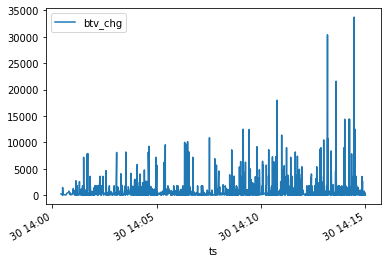

In [325]:
otms_tv_resampled_diff.xs('OTM_6PE',level=1,axis=1).query('(btv_chg != 0)')[['btv_chg']].plot()

for calls atv - btv 
for puts btv - atv

In [435]:
[i for i in otms_tv_resampled_diff.columns if i[1][-2:] == 'CE'][0]

('atv_chg', 'ATMCE')

In [450]:
otms_tv_resampled_diff['CE_BTV-ATV'] = 0
otms_tv_resampled_diff['PE_ATV-BTV'] = 0

In [451]:
for chg,instrument_type in otms_tv_resampled_diff.columns:
    try:
        if instrument_type[-2:] == 'CE':
            otms_tv_resampled_diff['CE_BTV-ATV'] += otms_tv_resampled_diff.xs(instrument_type,level=1,axis=1)['atv_chg'] - otms_tv_resampled_diff.xs(instrument_type,level=1,axis=1)['btv_chg']
        elif instrument_type[-2:] == 'PE':
            otms_tv_resampled_diff['PE_ATV-BTV'] += otms_tv_resampled_diff.xs(instrument_type,level=1,axis=1)['btv_chg'] - otms_tv_resampled_diff.xs(instrument_type,level=1,axis=1)['atv_chg']
        else:
            print('skipped',instrument_type)
    except Exception as e:
        print(e,instrument_type)

skipped 
skipped 


In [448]:
otms_tv_resampled_diff.head()

atv_chg                                \
opt_class                          ATMCE ATMPE ITM_1CE ITM_1PE OTM_1CE   
ts                                                                       
2024-04-30 13:50:00.019000+05:30     0.0   0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.022000+05:30     0.0   0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.026000+05:30    80.0   0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.036000+05:30     0.0   0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.051000+05:30     0.0   0.0     0.0     0.0     0.0   

                                                                          \
opt_class                        OTM_1PE OTM_2CE OTM_2PE OTM_3CE OTM_3PE   
ts                                                                         
2024-04-30 13:50:00.019000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.022000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.026000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.036000+05:30     0.0   160.0     0.0     0.0     0.0   
2024-04-30 13:50:00.051000+05:30     0.0     0.0   360.0     0.0     0.0   

                                                                          \
opt_class                        OTM_4CE OTM_4PE OTM_5CE OTM_5PE OTM_6CE   
ts                                                                         
2024-04-30 13:50:00.019000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.022000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.026000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.036000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.051000+05:30     0.0     0.0     0.0     0.0     0.0   

                                         btv_chg                          \
opt_class                        OTM_6PE   ATMCE   ATMPE ITM_1CE ITM_1PE   
ts                                                                         
2024-04-30 13:50:00.019000+05:30     0.0     0.0  1000.0     0.0     0.0   
2024-04-30 13:50:00.022000+05:30     0.0     0.0    40.0     0.0     0.0   
2024-04-30 13:50:00.026000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.036000+05:30     0.0     0.0    40.0     0.0     0.0   
2024-04-30 13:50:00.051000+05:30     0.0     0.0     0.0     0.0     0.0   

                                                                          \
opt_class                        OTM_1CE OTM_1PE OTM_2CE OTM_2PE OTM_3CE   
ts                                                                         
2024-04-30 13:50:00.019000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.022000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.026000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.036000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.051000+05:30     0.0   160.0     0.0     0.0     0.0   

                                                                          \
opt_class                        OTM_3PE OTM_4CE OTM_4PE OTM_5CE OTM_5PE   
ts                                                                         
2024-04-30 13:50:00.019000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.022000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.026000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.036000+05:30     0.0     0.0     0.0     0.0     0.0   
2024-04-30 13:50:00.051000+05:30   240.0     0.0     0.0     0.0     0.0   

                                                 CE_BTV-ATV PE_ATV-BTV  
opt_class                        OTM_6CE OTM_6PE                        
ts                                                                      
2024-04-30 13:50:00.019000+05:30     0.0     0.0        0.0     2000.0  
2024-04-30 13:50:00.022000+05:30     0.0     0.0        0.0       80.0  
2024-04-30 13:50:00.026000+05:

In [452]:
to_plot = otms_tv_resampled_diff[['CE_BTV-ATV','PE_ATV-BTV']]

In [458]:
to_plot['fut'] = otms_raw.set_index('ts').fut_mid.resample('1ms').last().fillna(method='ffill')

In [459]:
to_plot.to_csv('data/diffs.csv')

<AxesSubplot:xlabel='ts'>

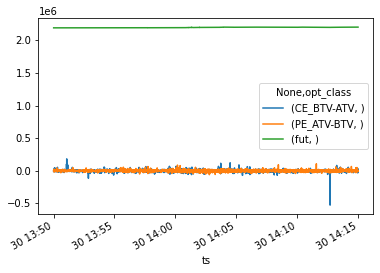

In [460]:
to_plot.plot()

In [485]:
to_plot.columns

Index(['CE_BTV-ATV', 'PE_ATV-BTV', 'fut', 'diff'], dtype='object')

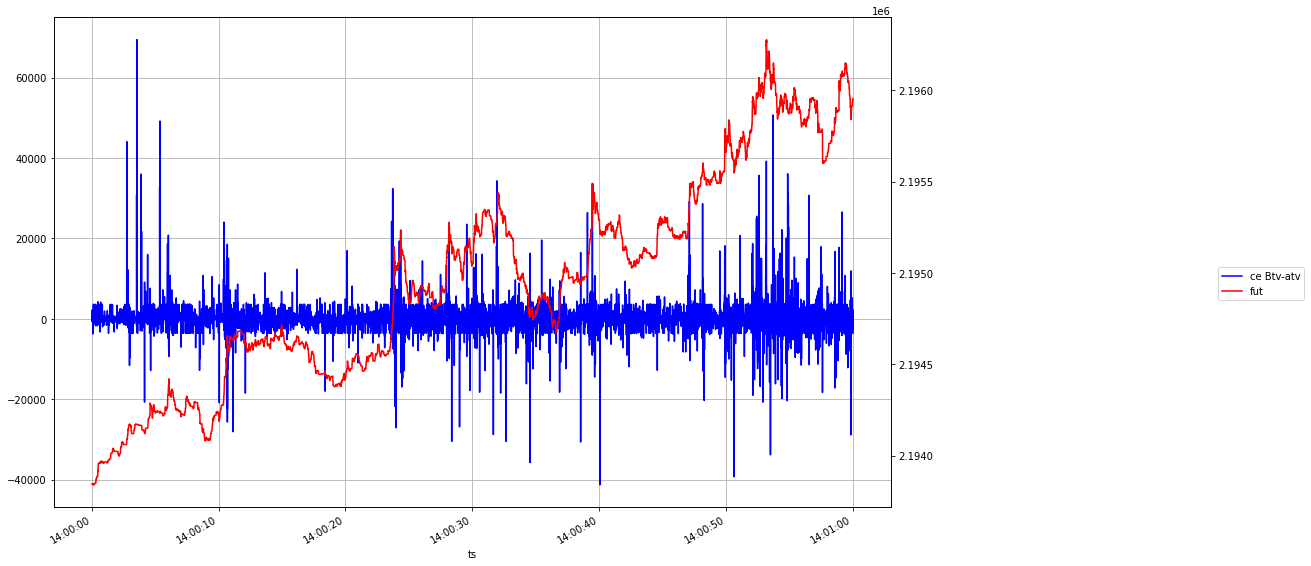

In [488]:
chunk=to_plot[(to_plot.index>'2024-04-30 14:00:00.019000+05:30') & (to_plot.index<'2024-04-30 14:01:00.019000+05:30')]
fig, ax = plt.subplots(figsize=(15,10))
chunk['CE_BTV-ATV'].plot(ax=ax, style='b-',grid=True)

chunk.fut.plot(ax=ax, style='r-', secondary_y=True,grid=True)

ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]],['ce Btv-atv','fut'],bbox_to_anchor=(1.5, 0.5))



In [483]:
req_opt_raw.name.unique()

array(['FINNIFTY24APRFUT', 'FINNIFTY24APR21400PE', 'FINNIFTY24APR21500PE',
       'FINNIFTY24APR21600PE', 'FINNIFTY24APR21700PE',
       'FINNIFTY24APR21800PE', 'FINNIFTY24APR21800CE',
       'FINNIFTY24APR21900CE', 'FINNIFTY24APR21900PE',
       'FINNIFTY24APR22000PE', 'FINNIFTY24APR22000CE',
       'FINNIFTY24APR22100CE', 'FINNIFTY24APR22200CE',
       'FINNIFTY24APR22300CE', 'FINNIFTY24APR22400CE',
       'FINNIFTY24APR22500CE'], dtype=object)

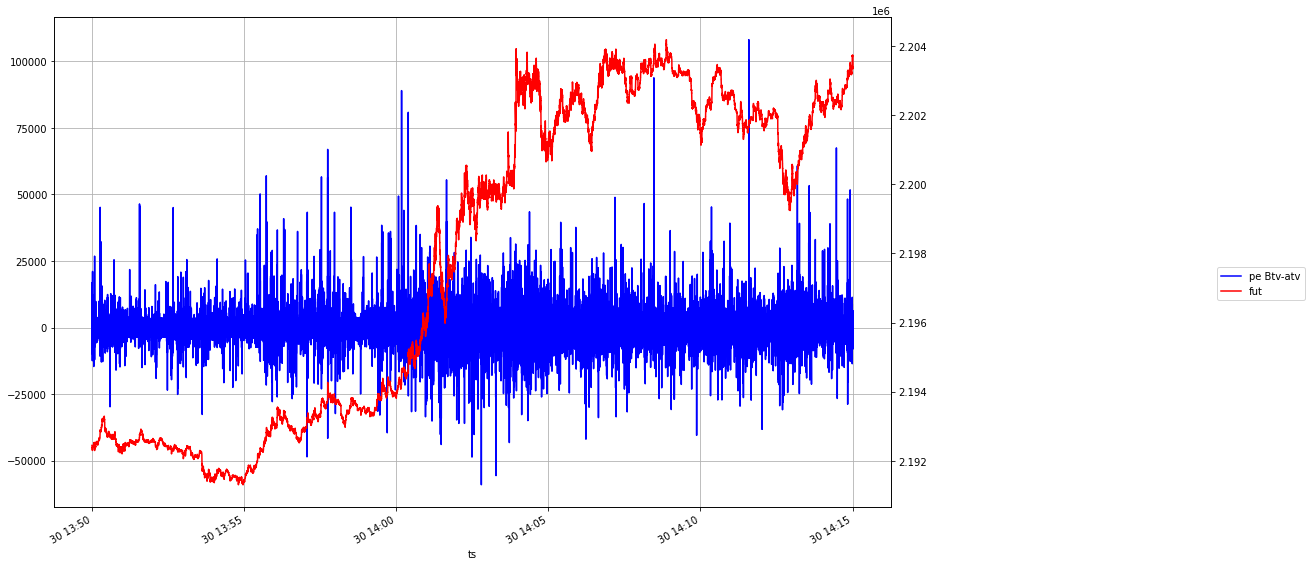

In [467]:
fig, ax = plt.subplots(figsize=(15,10))
to_plot['PE_ATV-BTV'].plot(ax=ax, style='b-',grid=True)

to_plot.fut.plot(ax=ax, style='r-', secondary_y=True,grid=True)

ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]],['pe Btv-atv','fut'],bbox_to_anchor=(1.5, 0.5))



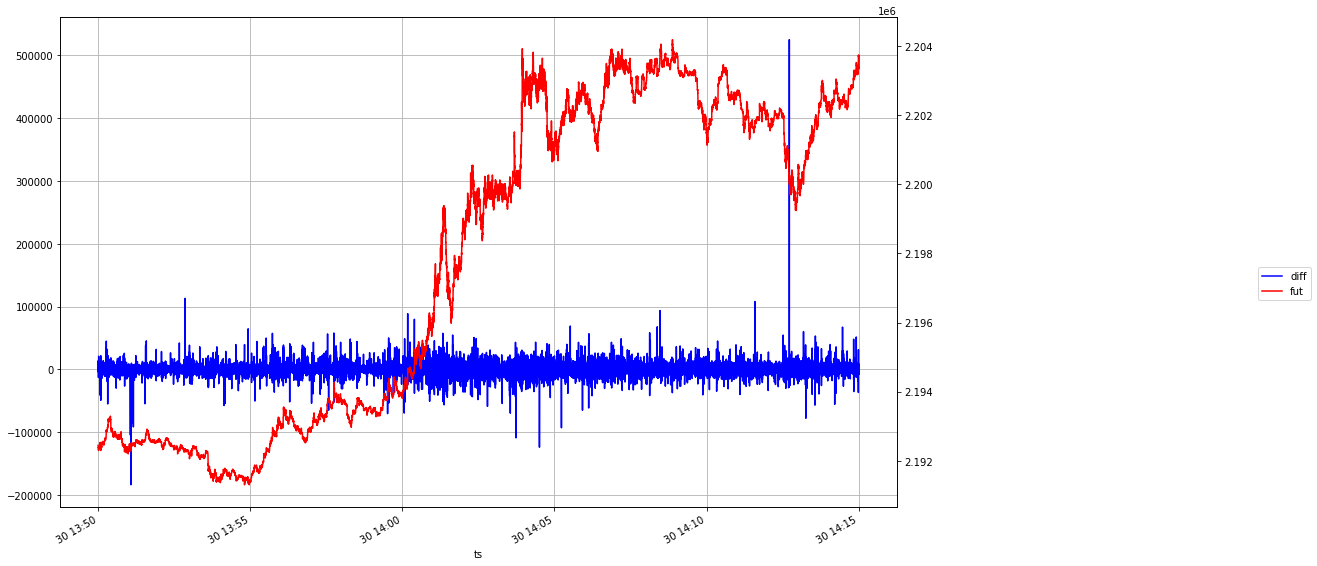

In [466]:
to_plot['diff'] = to_plot['PE_ATV-BTV'] - to_plot['CE_BTV-ATV']
fig, ax = plt.subplots(figsize=(15,10))
to_plot['diff'].plot(ax=ax, style='b-',grid=True)

to_plot.fut.plot(ax=ax, style='r-', secondary_y=True,grid=True)

ax.legend([ax.get_lines()[0], ax.right_ax.get_lines()[0]],['diff','fut'],bbox_to_anchor=(1.5, 0.5))



In [469]:
to_plot.head()

,CE_BTV-ATV,PE_ATV-BTV,fut,diff
opt_class,,,,
ts,,,,
2024-04-30 13:50:00.019000+05:30,0.0,2000.0,2192450.0,2000.0
2024-04-30 13:50:00.022000+05:30,0.0,80.0,2192450.0,80.0
2024-04-30 13:50:00.026000+05:30,160.0,0.0,2192450.0,-160.0
2024-04-30 13:50:00.036000+05:30,320.0,80.0,2192450.0,-240.0
2024-04-30 13:50:00.051000+05:30,0.0,80.0,2192445.0,80.0


Index(['CE_BTV-ATV', 'PE_ATV-BTV', 'fut', 'diff'], dtype='object')

In [474]:
to_plot.columns = to_plot.columns.droplevel(1) 

In [477]:
to_plot.query('diff > 400000').head()

,CE_BTV-ATV,PE_ATV-BTV,fut,diff
ts,,,,
2024-04-30 14:12:43.261000+05:30,-525120.0,0.0,2200000.0,525120.0


In [352]:
all_tbt.head()

,MachineTS,ExchTstamp,SeqNum,SecurityId,Type,Side,bid_size[0],bid[0],ask[0],ask_size[0],bid_size[1],bid[1],ask[1],ask_size[1],bid_size[2],bid[2],ask[2],ask_size[2],bid_size[3],bid[3],ask[3],ask_size[3],bid_size[4],bid[4],ask[4],ask_size[4],price,qty,old_price,old_qty,likely_bid_size,likely_bid,likely_ask,likely_ask_size,btc,atc,btv,atv,dprLow,dprHigh,ExchId1,ExchId2,ts,mid,fut_mid
0,1714465200008839276,1714465200008823458,765454715,35051,M,S,80,2192230,2192670,40,200,2192225,2192675,40,80,2192215,2192680,200,240,2192210,2192685,480,80,2192205,2192690,200,2192670,40,2192675,40,0,0,0,0,725,814,35360,38160,0,0,1900000193978353,0,2024-04-30 13:50:00.008839276+05:30,2192450.0,2192450.0
16,1714465200008843428,1714465200008828261,765454716,37169,N,B,120,9180,9200,1280,160,9175,9205,600,200,9170,9210,1080,480,9165,9215,1360,720,9160,9220,1040,9180,120,0,0,0,0,0,0,208405,213171,25165560,25181920,0,0,1900000194191217,0,2024-04-30 13:50:00.008843428+05:30,9190.0,2192450.0
44,1714465200008848692,1714465200008837697,663643496,37156,M,S,1000,5155,5165,40,1080,5150,5170,80,3760,5145,5175,1080,1720,5140,5180,1480,1840,5135,5185,400,5180,160,5200,160,0,0,0,0,852444,857178,99274120,99319440,0,0,1200000202454107,0,2024-04-30 13:50:00.008848692+05:30,5160.0,2192450.0
45,1714465200008854612,1714465200008842997,663643497,37156,X,B,720,5155,5165,40,1080,5150,5170,80,3760,5145,5175,1080,1720,5140,5180,1480,1840,5135,5185,400,5155,280,0,0,0,0,0,0,852444,857178,99274120,99319440,0,0,1200000202458881,0,2024-04-30 13:50:00.008854612+05:30,5160.0,2192450.0
1,1714465200008855196,1714465200008838088,765454719,35051,M,S,80,2192230,2192670,40,200,2192225,2192675,80,80,2192215,2192680,200,240,2192210,2192685,440,80,2192205,2192690,200,2192675,40,2192685,40,0,0,0,0,725,814,35360,38160,0,0,1900000193981716,0,2024-04-30 13:50:00.008855196+05:30,2192450.0,2192450.0


In [355]:
req_opt_raw.head()

,id,underlying,expiry,strike,option_type,tick_size,lot_size,name,exch,segment,security_type,date,expiry_date,strike_distance
50,35051,FINNIFTY,1714467600,-1,XX,5,40,FINNIFTY24APRFUT,NSE,FO,FUTIDX,20240430,20240430,218.0
1815,37128,FINNIFTY,1714467600,2140000,PE,5,40,FINNIFTY24APR21400PE,NSE,FO,OPTIDX,20240430,20240430,4.0
1821,37134,FINNIFTY,1714467600,2150000,PE,5,40,FINNIFTY24APR21500PE,NSE,FO,OPTIDX,20240430,20240430,3.0
1831,37144,FINNIFTY,1714467600,2160000,PE,5,40,FINNIFTY24APR21600PE,NSE,FO,OPTIDX,20240430,20240430,2.0
1837,37150,FINNIFTY,1714467600,2170000,PE,5,40,FINNIFTY24APR21700PE,NSE,FO,OPTIDX,20240430,20240430,1.0


In [402]:
for_iv_raw = pd.merge(all_tbt[['ts','SecurityId','mid','fut_mid']],req_opt_raw[['id','strike','option_type','name','expiry']],left_on='SecurityId',right_on="id",how="left").query('strike != -1')

convert_rs = True


In [403]:
if convert_rs:
    for_iv_raw[['mid','fut_mid','strike']] = for_iv_raw[['mid','fut_mid','strike']]/100
    convert_rs = False

In [404]:
try:
    for_iv_raw['expiry'] = pd.to_datetime(for_iv_raw.expiry,unit="s").dt.tz_localize('Asia/Kolkata') + pd.Timedelta(hours=6,minutes=30)
except Exception as e:
    print(e)


In [406]:
for_iv_raw.head()

,ts,SecurityId,mid,fut_mid,id,strike,option_type,name,expiry
1,2024-04-30 13:50:00.008843428+05:30,37169,91.9,21924.5,37169,22000.0,PE,FINNIFTY24APR22000PE,2024-04-30 15:30:00+05:30
2,2024-04-30 13:50:00.008848692+05:30,37156,51.6,21924.5,37156,21900.0,CE,FINNIFTY24APR21900CE,2024-04-30 15:30:00+05:30
3,2024-04-30 13:50:00.008854612+05:30,37156,51.6,21924.5,37156,21900.0,CE,FINNIFTY24APR21900CE,2024-04-30 15:30:00+05:30
7,2024-04-30 13:50:00.008868552+05:30,37156,51.6,21924.5,37156,21900.0,CE,FINNIFTY24APR21900CE,2024-04-30 15:30:00+05:30
9,2024-04-30 13:50:00.008871464+05:30,37156,51.6,21924.5,37156,21900.0,CE,FINNIFTY24APR21900CE,2024-04-30 15:30:00+05:30


In [407]:
for_iv_raw['tte'] = (for_iv_raw['expiry']-for_iv_raw['ts'])/pd.Timedelta(days=252)

In [408]:
for_iv_raw['moneyness'] = (for_iv_raw['strike'] - for_iv_raw['fut_mid']) * for_iv_raw['option_type'].map({'CE':-1,'PE':1})

ATM_Moneyness_threshold = 100
for_iv = for_iv_raw.query(f'moneyness <= {ATM_Moneyness_threshold}')


strike_multiplier = 100
for_iv['strike_distance'] = round(for_iv.moneyness/strike_multiplier).astype(int)
for_iv['opt_class'] = for_iv['strike_distance'].apply(mark_option_class ) + for_iv.option_type



In [409]:
for_iv.head()

,ts,SecurityId,mid,fut_mid,id,strike,option_type,name,expiry,tte,moneyness,strike_distance,opt_class
1,2024-04-30 13:50:00.008843428+05:30,37169,91.9,21924.5,37169,22000.0,PE,FINNIFTY24APR22000PE,2024-04-30 15:30:00+05:30,0.000275573,75.5,1,ITM_1PE
2,2024-04-30 13:50:00.008848692+05:30,37156,51.6,21924.5,37156,21900.0,CE,FINNIFTY24APR21900CE,2024-04-30 15:30:00+05:30,0.000275573,24.5,0,ATMCE
3,2024-04-30 13:50:00.008854612+05:30,37156,51.6,21924.5,37156,21900.0,CE,FINNIFTY24APR21900CE,2024-04-30 15:30:00+05:30,0.000275573,24.5,0,ATMCE
7,2024-04-30 13:50:00.008868552+05:30,37156,51.6,21924.5,37156,21900.0,CE,FINNIFTY24APR21900CE,2024-04-30 15:30:00+05:30,0.000275573,24.5,0,ATMCE
9,2024-04-30 13:50:00.008871464+05:30,37156,51.6,21924.5,37156,21900.0,CE,FINNIFTY24APR21900CE,2024-04-30 15:30:00+05:30,0.000275573,24.5,0,ATMCE


In [410]:
for_iv['option_type'] = for_iv['option_type'].str.slice(0,1).str.lower()

In [418]:
for_iv['irate'] = 0.0000001

In [414]:
for_iv[['ts','strike','option_type','tte','irate','mid','fut_mid']].head()

,ts,strike,option_type,tte,irate,mid,fut_mid
1,2024-04-30 13:50:00.008843428+05:30,22000.0,p,0.000275573,0,91.9,21924.5
2,2024-04-30 13:50:00.008848692+05:30,21900.0,c,0.000275573,0,51.6,21924.5
3,2024-04-30 13:50:00.008854612+05:30,21900.0,c,0.000275573,0,51.6,21924.5
7,2024-04-30 13:50:00.008868552+05:30,21900.0,c,0.000275573,0,51.6,21924.5
9,2024-04-30 13:50:00.008871464+05:30,21900.0,c,0.000275573,0,51.6,21924.5


In [400]:
from py_vollib_vectorized import price_dataframe

In [422]:
from py_vollib_vectorized.implied_volatility import vectorized_implied_volatility


In [425]:
for_iv['iv']= vectorized_implied_volatility(
    for_iv.mid, for_iv.fut_mid, for_iv.strike,
    for_iv.tte, 0, for_iv.option_type, return_as='numpy')


In [426]:
for_iv.head()

,ts,SecurityId,mid,fut_mid,id,strike,option_type,name,expiry,tte,moneyness,strike_distance,opt_class,irate,iv
1,2024-04-30 13:50:00.008843428+05:30,37169,91.9,21924.5,37169,22000.0,p,FINNIFTY24APR22000PE,2024-04-30 15:30:00+05:30,0.000275573,75.5,1,ITM_1PE,0.0000001,0.304469699
2,2024-04-30 13:50:00.008848692+05:30,37156,51.6,21924.5,37156,21900.0,c,FINNIFTY24APR21900CE,2024-04-30 15:30:00+05:30,0.000275573,24.5,0,ATMCE,0.0000001,0.262571094
3,2024-04-30 13:50:00.008854612+05:30,37156,51.6,21924.5,37156,21900.0,c,FINNIFTY24APR21900CE,2024-04-30 15:30:00+05:30,0.000275573,24.5,0,ATMCE,0.0000001,0.262571095
7,2024-04-30 13:50:00.008868552+05:30,37156,51.6,21924.5,37156,21900.0,c,FINNIFTY24APR21900CE,2024-04-30 15:30:00+05:30,0.000275573,24.5,0,ATMCE,0.0000001,0.262571095
9,2024-04-30 13:50:00.008871464+05:30,37156,51.6,21924.5,37156,21900.0,c,FINNIFTY24APR21900CE,2024-04-30 15:30:00+05:30,0.000275573,24.5,0,ATMCE,0.0000001,0.262571095


In [97]:
convert_rs = True
chain_raw = pd.merge_asof(bcast_w_syminfo.query(f'symid != {fut_id}'),fut,on='timestamp',direction='backward').dropna(subset=['fut_ltp'])

In [98]:
if convert_rs:
    chain_raw[['bid_price','ask_price','ltp','open','low','high','close','fut_ltp','strike']] = chain_raw[['bid_price','ask_price','ltp','open','low','high','close','fut_ltp','strike']]/100
    convert_rs = False


In [99]:
chain_raw.head()

,timestamp,bid_price,ask_price,ltp,volume,total_buyqty,total_sellqty,iv,bid_qty,ask_qty,ltq,atp,oi,open,high,low,close,symid,name,strike,fut_ltp
51,2024-04-30 09:15:00.106404+05:30,0.00,2.10,2.10,640,0.0,7000.0,50.0,0,280,640,210,597960,2.1,2.1,2.10,5.10,41201,FINNIFTY24APR21250PE,21250.0,21820.6
52,2024-04-30 09:15:00.107567+05:30,6.50,8.55,8.95,400,853920.0,28560.0,50.0,480,520,80,883,655440,8.0,9.9,6.45,16.45,41215,FINNIFTY24APR21550PE,21550.0,21820.6
53,2024-04-30 09:15:00.108498+05:30,1.00,1.85,1.85,600,40.0,17840.0,50.0,40,1600,400,206,1193680,2.5,2.5,1.85,4.00,37106,FINNIFTY24APR21100PE,21100.0,21820.6
54,2024-04-30 09:15:00.177317+05:30,0.30,0.40,0.40,120,1241200.0,4920.0,50.0,40040,1120,120,40,276440,0.4,0.4,0.40,0.50,37201,FINNIFTY24APR23000CE,23000.0,21820.6
55,2024-04-30 09:15:00.177317+05:30,0.15,1.95,0.40,0,166080.0,400.0,50.0,4480,400,120,0,0,0.0,0.0,0.00,0.50,37195,FINNIFTY24APR22900CE,22900.0,21820.6


In [162]:
chain = chain_raw[['timestamp','total_buyqty','total_sellqty','name','strike','fut_ltp']]#.groupby(['name']).apply(lambda x : x.set_index('timestamp').resample('1s').agg({'total_buyqty':'sum',
#                                                                                                               'total_sellqty':'sum',
#                                                                                                               'fut_ltp':'last',
#                                                                                                               'strike':'first'})).reset_index().sort_values('timestamp').reset_index(drop=True)

In [163]:
chain['name'].head().str.extract('(^[A-Z&-]+)(.{5})(\d+)(.{2}$)')[3]

51    PE
52    PE
53    PE
54    CE
55    CE
Name: 3, dtype: object

In [165]:
chain['opt_type'] = chain['name'].str.extract('(^[A-Z&-]+)(.{5})(\d+)(.{2}$)')[3]

In [166]:
chain['moneyness'] = ((chain['fut_ltp'] - chain['strike'])* chain['opt_type'].map({'CE':1,'PE':-1})).apply(lambda x : max(0,x))
chain['strike_dist'] = ((chain['fut_ltp'] - chain['strike'])* chain['opt_type'].map({'CE':1,'PE':-1})).apply(lambda x : max(0,x))

In [167]:
chain.head(10)

,timestamp,total_buyqty,total_sellqty,name,strike,fut_ltp,opt_type,moneyness,strike_dist
51,2024-04-30 09:15:00.106404+05:30,0.0,7000.0,FINNIFTY24APR21250PE,21250.0,21820.6,PE,0.0,0.0
52,2024-04-30 09:15:00.107567+05:30,853920.0,28560.0,FINNIFTY24APR21550PE,21550.0,21820.6,PE,0.0,0.0
53,2024-04-30 09:15:00.108498+05:30,40.0,17840.0,FINNIFTY24APR21100PE,21100.0,21820.6,PE,0.0,0.0
54,2024-04-30 09:15:00.177317+05:30,1241200.0,4920.0,FINNIFTY24APR23000CE,23000.0,21820.6,CE,0.0,0.0
55,2024-04-30 09:15:00.177317+05:30,166080.0,400.0,FINNIFTY24APR22900CE,22900.0,21820.6,CE,0.0,0.0
56,2024-04-30 09:15:00.178196+05:30,72000.0,0.0,FINNIFTY24APR23200CE,23200.0,21820.6,CE,0.0,0.0
57,2024-04-30 09:15:00.178196+05:30,66640.0,0.0,FINNIFTY24APR23100CE,23100.0,21820.6,CE,0.0,0.0
58,2024-04-30 09:15:00.180253+05:30,320.0,0.0,FINNIFTY24APR20950CE,20950.0,21820.6,CE,870.6,870.6
59,2024-04-30 09:15:00.181426+05:30,320.0,0.0,FINNIFTY24APR20800CE,20800.0,21820.6,CE,1020.6,1020.6
60,2024-04-30 09:15:00.182517+05:30,7880.0,2640.0,FINNIFTY24APR21400CE,21400.0,21820.6,CE,420.6,420.6


In [173]:
from matplotlib import pyplot as plt

<AxesSubplot:xlabel='timestamp'>

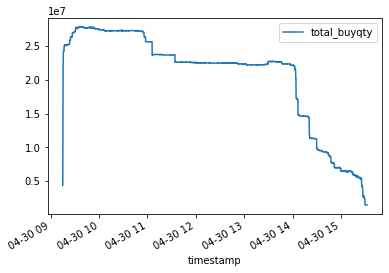

In [178]:
chain.query('name == "FINNIFTY24APR21800CE"')[['timestamp','total_buyqty']].set_index('timestamp').plot()

In [168]:
otms_raw = chain.query('moneyness == 0')

In [169]:
otms_raw.head()

,timestamp,total_buyqty,total_sellqty,name,strike,fut_ltp,opt_type,moneyness,strike_dist
51,2024-04-30 09:15:00.106404+05:30,0.0,7000.0,FINNIFTY24APR21250PE,21250.0,21820.6,PE,0.0,0.0
52,2024-04-30 09:15:00.107567+05:30,853920.0,28560.0,FINNIFTY24APR21550PE,21550.0,21820.6,PE,0.0,0.0
53,2024-04-30 09:15:00.108498+05:30,40.0,17840.0,FINNIFTY24APR21100PE,21100.0,21820.6,PE,0.0,0.0
54,2024-04-30 09:15:00.177317+05:30,1241200.0,4920.0,FINNIFTY24APR23000CE,23000.0,21820.6,CE,0.0,0.0
55,2024-04-30 09:15:00.177317+05:30,166080.0,400.0,FINNIFTY24APR22900CE,22900.0,21820.6,CE,0.0,0.0


In [154]:
otms_raw_resampled = otms_raw.groupby(['name']).apply(lambda x : x.set_index('timestamp').resample('1s').agg({'total_buyqty':'sum',
                                                                                                              'total_sellqty':'sum',
                                                                                                              'opt_type':'first','fut_ltp':'last',
                                                                                                              'strike':'first'})).reset_index().sort_values('timestamp').reset_index(drop=True)

In [ ]:
otms_raw_resampled['']

In [155]:
otms_raw_resampled.head()

,name,timestamp,total_buyqty,total_sellqty,opt_type,fut_ltp,strike
0,FINNIFTY24APR19750PE,2024-04-30 09:15:00+05:30,17520.0,9440.0,PE,21820.6,19750.0
1,FINNIFTY24APR23900CE,2024-04-30 09:15:00+05:30,91800.0,3600.0,CE,21820.6,23900.0
2,FINNIFTY24APR21700PE,2024-04-30 09:15:00+05:30,1866600.0,86120.0,PE,21820.6,21700.0
3,FINNIFTY24APR22100CE,2024-04-30 09:15:00+05:30,3203640.0,34840.0,CE,21820.6,22100.0
4,FINNIFTY24APR19950PE,2024-04-30 09:15:00+05:30,27480.0,5800.0,PE,21820.6,19950.0


In [ ]:
strike,fut,tte,interest,iv,price

In [137]:
otms_qty = otms_raw.pivot_table(index=['timestamp','opt_type'],columns=['strike'],values=['total_buyqty','total_sellqty'],fill_value=0)

In [ ]:
otms_qty = otms_raw.pivot_table(index=['timestamp','opt_type'],columns=['strike'],values=['total_buyqty','total_sellqty'],fill_value=0)

In [139]:
otms_qty.head()

total_buyqty                  \
strike                                         17000.0 17500.0 17900.0   
timestamp                        opt_type                                
2024-04-30 09:15:00.106404+05:30 PE                  0       0       0   
2024-04-30 09:15:00.107567+05:30 PE                  0       0       0   
2024-04-30 09:15:00.108498+05:30 PE                  0       0       0   
2024-04-30 09:15:00.177317+05:30 CE                  0       0       0   
2024-04-30 09:15:00.178196+05:30 CE                  0       0       0   

                                                                           \
strike                                    18000.0 18100.0 18200.0 18300.0   
timestamp                        opt_type                                   
2024-04-30 09:15:00.106404+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.107567+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.108498+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.177317+05:30 CE             0       0       0       0   
2024-04-30 09:15:00.178196+05:30 CE             0       0       0       0   

                                                                           \
strike                                    18400.0 18500.0 18600.0 18700.0   
timestamp                        opt_type                                   
2024-04-30 09:15:00.106404+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.107567+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.108498+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.177317+05:30 CE             0       0       0       0   
2024-04-30 09:15:00.178196+05:30 CE             0       0       0       0   

                                                                           \
strike                                    18800.0 18900.0 19000.0 19100.0   
timestamp                        opt_type                                   
2024-04-30 09:15:00.106404+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.107567+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.108498+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.177317+05:30 CE             0       0       0       0   
2024-04-30 09:15:00.178196+05:30 CE             0       0       0       0   

                                                                           \
strike                                    19200.0 19300.0 19400.0 19450.0   
timestamp                        opt_type                                   
2024-04-30 09:15:00.106404+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.107567+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.108498+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.177317+05:30 CE             0       0       0       0   
2024-04-30 09:15:00.178196+05:30 CE             0       0       0       0   

                                                                           \
strike                                    19500.0 19550.0 19600.0 19650.0   
timestamp                        opt_type                                   
2024-04-30 09:15:00.106404+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.107567+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.108498+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.177317+05:30 CE             0       0       0       0   
2024-04-30 09:15:00.178196+05:30 CE             0       0       0       0   

                                                                           \
strike                                    19700.0 19750.0 19800.0 19850.0   
timestamp                        opt_type                                   
2024-04-30 09:15:00.106404+05:30 PE             0       0       0       0   
2024-04-30 09:15:00.107567+05:30 PE             0       

In [128]:
otms_raw.tail()

,timestamp,total_buyqty,total_sellqty,name,strike,fut_ltp,opt_type,moneyness
1294781,2024-04-30 15:32:25.637301+05:30,99240.0,104160.0,FINNIFTY24APR22150CE,22150.0,21844.0,CE,0.0
1294782,2024-04-30 15:32:25.637301+05:30,0.0,139080.0,FINNIFTY24APR22550CE,22550.0,21844.0,CE,0.0
1294783,2024-04-30 15:32:25.639555+05:30,0.0,131400.0,FINNIFTY24APR22050CE,22050.0,21844.0,CE,0.0
1294785,2024-04-30 15:32:25.639584+05:30,235120.0,381520.0,FINNIFTY24APR21850CE,21850.0,21844.0,CE,0.0
1294786,2024-04-30 15:32:25.639584+05:30,0.0,224920.0,FINNIFTY24APR21900CE,21900.0,21844.0,CE,0.0
